<a href="https://colab.research.google.com/github/abhinavsagar/Breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading & Preprocessing

In [0]:
!git clone https://github.com/abhinavsagar/breast.git

Cloning into 'breast'...
remote: Enumerating objects: 1198, done.
remote: Counting objects: 100% (1198/1198), done.
remote: Compressing objects: 100% (1196/1196), done.
remote: Total 1198 (delta 1), reused 1192 (delta 0), pack-reused 0
Receiving objects: 100% (1198/1198), 569.51 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (1186/1186), done.


In [0]:
%cd breast

/content/breast/breast


In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

Using TensorFlow backend.


In [2]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('data/train/benign',224))
malign_train = np.array(Dataset_loader('data/train/malignant',224))
benign_test = np.array(Dataset_loader('data/validation/benign',224))
malign_test = np.array(Dataset_loader('data/validation/malignant',224))

100%|██████████| 1082/1082 [00:35<00:00, 30.63it/s]


# Create Label

In [3]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

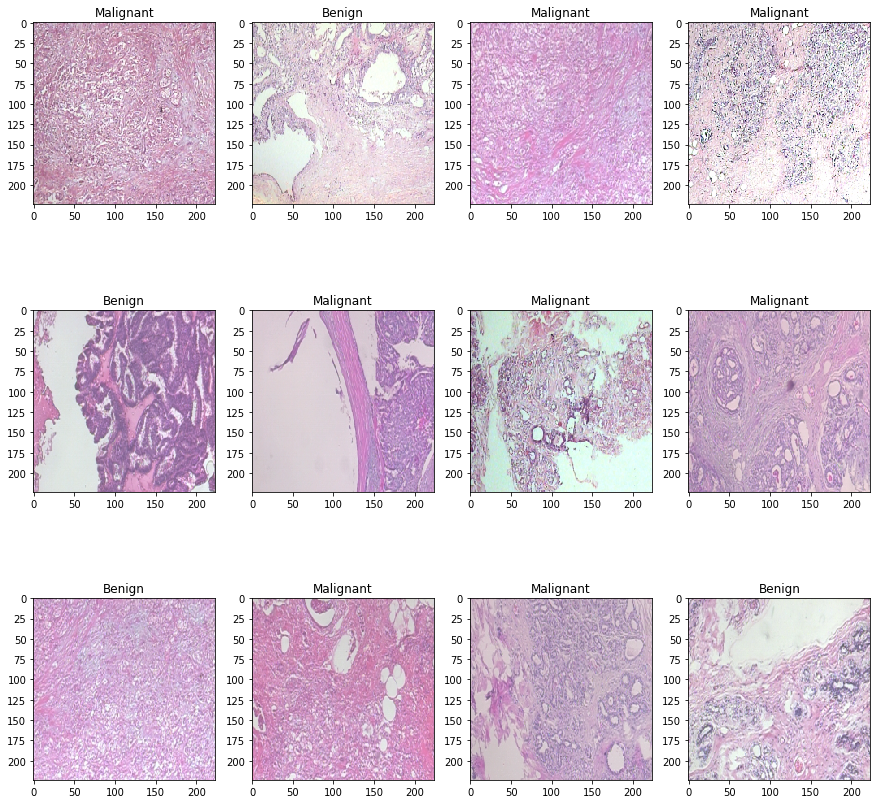

In [5]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [6]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [7]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [8]:
    model = Sequential()
  
  

In [9]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,

In [10]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [11]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)



Epoch 1/20
18/17 [==============================] - ETA: 21:56 - loss: 0.9162 - acc: 0.37 - ETA: 16:10 - loss: 0.9771 - acc: 0.37 - ETA: 13:47 - loss: 0.8603 - acc: 0.43 - ETA: 12:07 - loss: 0.8249 - acc: 0.50 - ETA: 10:58 - loss: 0.8455 - acc: 0.52 - ETA: 9:59 - loss: 0.7488 - acc: 0.5938 - ETA: 9:03 - loss: 0.7656 - acc: 0.598 - ETA: 8:06 - loss: 0.7478 - acc: 0.609 - ETA: 7:13 - loss: 0.7121 - acc: 0.611 - ETA: 6:19 - loss: 0.7080 - acc: 0.612 - ETA: 5:27 - loss: 0.7052 - acc: 0.613 - ETA: 4:36 - loss: 0.6828 - acc: 0.625 - ETA: 3:47 - loss: 0.6496 - acc: 0.649 - ETA: 2:56 - loss: 0.6653 - acc: 0.647 - ETA: 2:05 - loss: 0.6407 - acc: 0.658 - ETA: 1:14 - loss: 0.6349 - acc: 0.668 - ETA: 24s - loss: 0.6355 - acc: 0.672 - 977s 54s/step - loss: 0.6945 - acc: 0.6634 - val_loss: 0.1680 - val_acc: 0.9429

Epoch 00001: val_acc improved from -inf to 0.94286, saving model to weights.best.hdf5
Epoch 2/20
18/17 [==============================] - ETA: 13:21 - loss: 0.4480 - acc: 0.81 - ETA: 12

ResourceExhaustedError: OOM when allocating tensor with shape[16,7,7,1888] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node densenet201/conv5_block32_0_bn/FusedBatchNormV3 (defined at C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'densenet201/conv5_block32_0_bn/FusedBatchNormV3':
  File "C:\Users\lenovo\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lenovo\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\lenovo\Anaconda3\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Users\lenovo\Anaconda3\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\Users\lenovo\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-54d3b4f6d8f6>", line 14, in <module>
    model = build_model(resnet ,lr = 1e-4)
  File "<ipython-input-7-8607c21e1f44>", line 3, in build_model
    model.add(backbone)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\models.py", line 467, in add
    layer(x)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2236, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\layers\normalization.py", line 181, in call
    epsilon=self.epsilon)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1827, in normalize_batch_in_training
    epsilon=epsilon)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1802, in _fused_normalize_batch_in_training
    data_format=tf_data_format)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\ops\nn_impl.py", line 1501, in fused_batch_norm
    name=name)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\ops\gen_nn_ops.py", line 4620, in fused_batch_norm_v3
    name=name)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [ ]:
model.load_weights("weights.best_old.hdf5")
print('sfj')

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
print('complted')

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

### Confusion Matrix

Confusion matrix, without normalization
[[ 60  77]
 [ 10 140]]


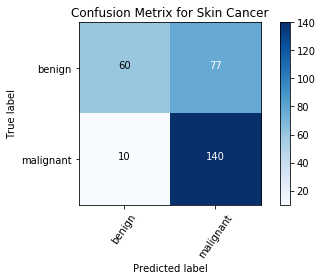

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[ 59  78]
 [  7 143]]


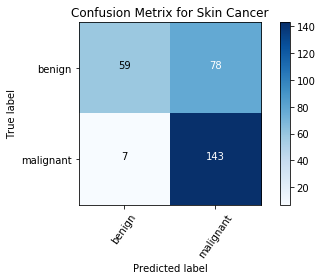

In [0]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [0]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.89      0.43      0.58       137\n           1       0.65      0.95      0.77       150\n\n    accuracy                           0.70       287\n   macro avg       0.77      0.69      0.68       287\nweighted avg       0.76      0.70      0.68       287\n'

### ROC and AUC

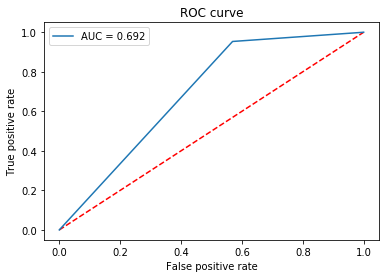

In [0]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()